# **IMPORTING LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from torchvision.transforms import transforms

# **LOADING DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
X_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/input.csv', delimiter = ',')
Y_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/labels.csv', delimiter = ',')

X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/input_test.csv', delimiter = ',')
Y_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/labels_test.csv', delimiter = ',')

In [ ]:
X_train=X_train.to_numpy()
Y_train = Y_train.to_numpy()
X_test = X_test.to_numpy()
Y_test=Y_test.to_numpy()


# **DATA PREPROCESSING**

In [ ]:
X_train = X_train.reshape(len(X_train), 100, 100, 3)
Y_train = Y_train.reshape(len(Y_train), 1)

X_test = X_test.reshape(len(X_test), 100, 100, 3)
Y_test = Y_test.reshape(len(Y_test), 1)

X_train = X_train/255.0
X_test = X_test/255.0                   #Way of noramlising the data

In [ ]:
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", Y_test.shape)

Shape of X_train:  (1999, 100, 100, 3)
Shape of Y_train:  (1999, 1)
Shape of X_test:  (399, 100, 100, 3)
Shape of Y_test:  (399, 1)


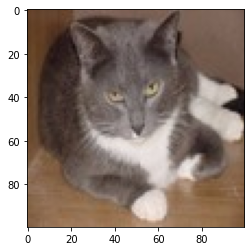

In [ ]:
idx = random.randint(0, len(X_train))    #picking random example using random function
plt.imshow(X_train[idx, :])
plt.show()

# **KERAS MODEL**

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape = (100, 100, 3)),
    MaxPooling2D((2,2)),
    
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (100, 100, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])  #MODEL COMPILATION

In [ ]:
import tensorflow as tf
Y_train = tf.stack(Y_train)
X_train = tf.stack(X_train)

# **MODEL TRAINING AND TESTING**

In [ ]:
model.fit(X_train, Y_train, epochs = 5, batch_size = 64)           #MODEL FITTING 

Epoch 1/5
32/32 [==============================] - 28s 805ms/step - loss: 0.7163 - accuracy: 0.5213
Epoch 2/5
32/32 [==============================] - 28s 863ms/step - loss: 0.6767 - accuracy: 0.5838
Epoch 3/5
32/32 [==============================] - 28s 875ms/step - loss: 0.6225 - accuracy: 0.6503
Epoch 4/5
32/32 [==============================] - 28s 882ms/step - loss: 0.5558 - accuracy: 0.7204
Epoch 5/5
32/32 [==============================] - 28s 888ms/step - loss: 0.4870 - accuracy: 0.7669


In [ ]:
model.evaluate(X_test, Y_test)

13/13 [==============================] - 1s 94ms/step - loss: 0.6833 - accuracy: 0.6241


[0.6833259463310242, 0.6240601539611816]

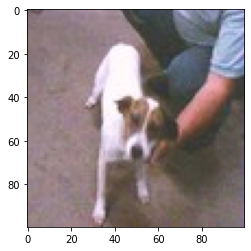

1/1 [==============================] - 0s 151ms/step
Our model says it is a : dog


In [ ]:
idx2 = random.randint(0, len(Y_test))
plt.imshow(X_test[idx2, :])
plt.show()

y_pred = model.predict(X_test[idx2, :].reshape(1, 100, 100, 3))
y_pred = y_pred > 0.5

if(y_pred == 0):
    pred = 'dog'
else:
    pred = 'cat'
    
print("Our model says it is a :", pred)

In [ ]:
model.save("kr_model.h5")     #saving model as h5 model

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from modeci_mdf.utils import simple_connect

# import mdf
from modeci_mdf.mdf import *

# for executing the graph
from modeci_mdf.execution_engine import EvaluableGraph

from modeci_mdf.utils import simple_connect

# from Keras_2_mdf import * #contains helper functions for this model


# import the necessary package to use Conditions in MDF
import graph_scheduler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten

**LOADING KERAS H5 MODEL**

In [ ]:
new_model = tf.keras.models.load_model("kr_model.h5")
for i in new_model.layers:                  #LAYERS AVAILABLE
    print(i.name)

conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
flatten_1
dense_2
dense_3


In [ ]:
# selective layers which will be used in MDF Model
layers_to_extract = ["conv2d_2", "dense_2", "dense_3"]


In [ ]:
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
def image_loader(loader, image):
    image = loader(image).float()
    image = image.clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# **FUNCTIONS**

In [ ]:
def get_weights_and_activation(layers, model):               #FUNCTION 1

    params = {}
    activations = []
    for layer in layers:
        n = {}
        lyr = model.get_layer(layer)
        wgts, bias = lyr.weights
        n["weights"], n["bias"] = wgts.numpy(), bias.numpy()
        params[layer] = n
        activations.append(str(lyr.activation).split()[1])
    return params, activations



In [ ]:
def init_model_with_graph(model_id, graph_id):             #FUNCTION 2
    mod = Model(id=model_id)
    mod_graph = Graph(id=graph_id)
    mod.graphs.append(mod_graph)
    return mod, mod_graph

In [ ]:
def create_input_node(node_id, value):                   #FUNCTION 3
    input_node = Node(id=node_id)
    input_node.parameters.append(
        Parameter(id=f"{node_id}_in", value=np.array(value).tolist())
    )
    input_node.output_ports.append(
        OutputPort(id=f"{node_id}_out", value=f"{node_id}_in")
    )
    return input_node

In [ ]:
def create_dense_node(node_id, weights, bias):          #FUNCTION 4
    node = Node(id=node_id)
    node.input_ports.append(InputPort(id=f"{node_id}_in"))
    # Weights
    node.parameters.append(Parameter(id="wgts", value=weights))
    # bias
    node.parameters.append(Parameter(id="bias", value=bias))
    # Value Weights + bias
    node.parameters.append(
        Parameter(id="Output", value=f"({node_id}_in @ wgts) + bias")
    )

    node.output_ports.append(Parameter(id=f"{node_id}_out", value="Output"))
    return node


In [ ]:
def create_activation_node(node_id, activation_name):                   #FUNCTION 5
    activation = Node(id=node_id)
    activation.input_ports.append(InputPort(id=f"{node_id}_in"))

    # Functionality of relu
    if activation_name == "relu":
        # Value of relu function
        relu_ = f"({node_id}_in > 0 ) "
        activation.parameters.append(Parameter(id="Output", value=relu_))

    # Functionality of sigmoid
    elif activation_name == "sigmoid":
        # args for exponential function
        args = {"variable0": "pos_in", "scale": 1, "rate": 1, "bias": 0, "offset": 0}

        # this will make x => x
        activation.parameters.append(Parameter(id="pos_in", value=f"{node_id}_in"))
        # value of e^x
        activation.functions.append(
            Function(id="exp", function="exponential", args=args)
        )
        # value of sigmoid
        activation.functions.append(Function(id="output", value="1 / (1 + exp)"))

    elif activation_name == "softmax":
        # args for exponential function
        args = {
            "variable0": f"{node_id}_in",
            "scale": 1,
            "rate": 1,
            "bias": 0,
            "offset": 0,
        }

        # exponential of each value
        activation.functions.append(
            Function(id="exp", function="exponential", args=args)
        )
        # sum of all exponentials
        activation.functions.append(Function(id="exp_sum", value="sum(exp)"))
        # normalizing results
        activation.functions.append(Function(id="Output", value="exp / exp_sum"))

    activation.output_ports.append(OutputPort(id=f"{node_id}_out", value="Output"))
    return activation

# **KERAS TO MDF**

In [ ]:
# Call the function to get weights and activation of layer       
params, activations = get_weights_and_activation(layers_to_extract, new_model)


In [ ]:
mod, mod_graph = init_model_with_graph("keras_to_MDF", "Keras_to_MDF_graph")

In [ ]:
input_node = create_input_node("input_node", [1.0])
mod_graph.nodes.append(input_node)
print(mod_graph.to_yaml())

Keras_to_MDF_graph:
    nodes:
        input_node:
            parameters:
                input_node_in:
                    value:
                    - 1.0
            output_ports:
                input_node_out:
                    value: input_node_in



In [ ]:
node = create_dense_node("dense_node", "weights", "bias")
mod_graph.nodes.append(node)
print(mod_graph.to_yaml())

Keras_to_MDF_graph:
    nodes:
        input_node:
            parameters:
                input_node_in:
                    value:
                    - 1.0
            output_ports:
                input_node_out:
                    value: input_node_in
        dense_node:
            input_ports:
                dense_node_in: {}
            parameters:
                wgts:
                    value: weights
                bias:
                    value: bias
                Output:
                    value: (dense_node_in @ wgts) + bias
            output_ports:
                dense_node_out:
                    value: Output



In [ ]:
activation = create_activation_node("activation_node", "activation_name")
mod_graph.nodes.append(activation)
print(mod_graph.to_yaml())

Keras_to_MDF_graph:
    nodes:
        input_node:
            parameters:
                input_node_in:
                    value:
                    - 1.0
            output_ports:
                input_node_out:
                    value: input_node_in
        dense_node:
            input_ports:
                dense_node_in: {}
            parameters:
                wgts:
                    value: weights
                bias:
                    value: bias
                Output:
                    value: (dense_node_in @ wgts) + bias
            output_ports:
                dense_node_out:
                    value: Output
        activation_node:
            input_ports:
                activation_node_in: {}
            output_ports:
                activation_node_out:
                    value: Output



In [ ]:
#  Save the model to file
mod.to_json_file("keras_to_MDF1.json")
mod.to_yaml_file("keras_to_MDF1.yaml")

'keras_to_MDF1.yaml'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

# Define a simple neural network model


**KERAS MODEL PLOT**

Plotting the model


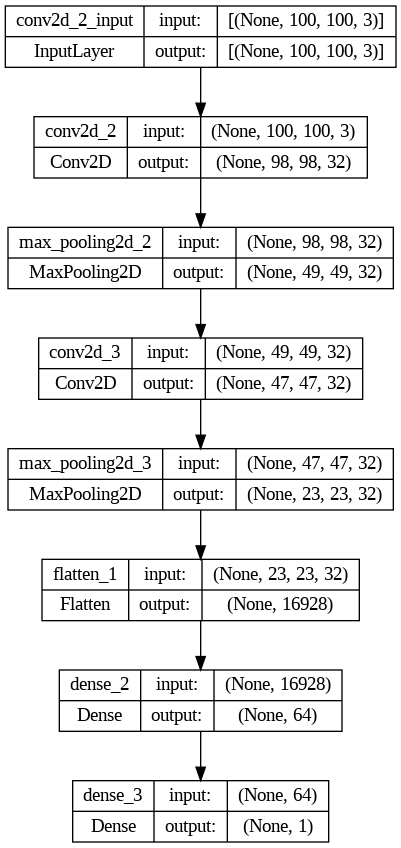

In [ ]:
# plot the model
print("Plotting the model")
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)